In [7]:
# need this to run on GPU
! pip3 install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
! pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [0]:
import argparse
import os
import numpy as np
import math
import itertools

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image
import pandas as pd

import torchvision.utils as vutils

import cv2

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# paths
base_dir = "drive/My Drive/"
cil_project_path = "/content/drive/My Drive/CIL_project/"
save_path = cil_project_path + "FFT_check/"

In [11]:
# get scored images
zip_scored = 'scored.zip'
path_scored = zip_scored[:-4] + '/'
path_scored_drive = cil_project_path + zip_scored

! cp '{path_scored_drive}' . 
! unzip -q '{zip_scored}'
! rm '{zip_scored}'

print('ok')

ok


In [12]:
# number of images in scored
! ls -l '{path_scored}'| grep -v ^l | wc -l

9601


In [13]:
# get query.zip stuff
zip_query = 'query.zip'
path_query = zip_query[:-4] + '/'
path_query_drive = cil_project_path + zip_query

! cp '{path_query_drive}' . 
! unzip -q '{zip_query}'
! rm '{zip_query}'

print('ok')

ok


In [16]:
# number of images in query
! ls -l '{path_query}'| grep -v ^l | wc -l

1201


In [0]:
# get csv for scored
csv_name = 'scored.csv'
csv_path = csv_name
csv_drive_path = cil_project_path + csv_name

! cp '{csv_drive_path}' . 

In [19]:
scores = pd.read_csv(csv_path, index_col="Id")
scores

,Actual
Id,
5694059,1.837794
9129611,0.002067
8058479,4.588517
1315360,2.325835
6813515,0.872309
...,...
1639624,1.653025
4342102,1.279719
6526641,1.308388


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff14bdaf550>]],
      dtype=object)

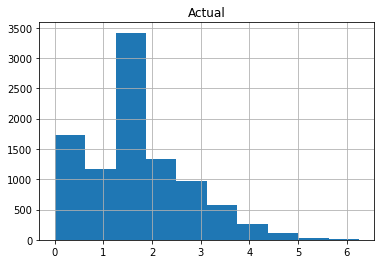

In [20]:
scores.hist()

In [21]:
scores.max()

Actual    6.249791
dtype: float64

Check for 1 image

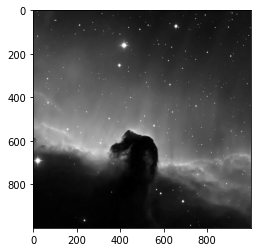

In [23]:
img_path = os.path.join(path_scored, "8553726.png")
img = cv2.imread(img_path,0) # load image


plt.imshow(img, cmap = 'gray')

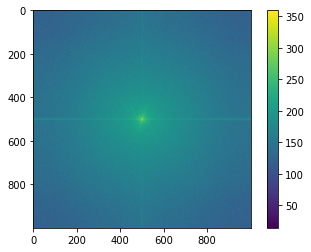

In [30]:
# fourier
f = np.fft.fft2(img, norm=None)

# center 
f = np.fft.fftshift(f)

# magnitude
magnitude_db = 20*np.log(np.abs(f))

plt.imshow(magnitude_db)
plt.colorbar()

In [31]:
magnitude_db.shape

(1000, 1000)

In [32]:
print(np.max(magnitude_db))

print(np.min(magnitude_db))

359.447562543284
14.51739588800345


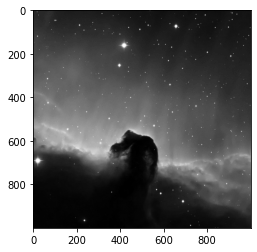

In [33]:
# inverse centering
img_init = np.fft.ifftshift(f)

# inverse fft
img_init = np.fft.ifft2(img_init)

plt.imshow(np.abs(img_init), cmap="gray")

Fourier is symmetric, so it should be enough for features to take half when the dataset will be generated

(1000, 500)
500000


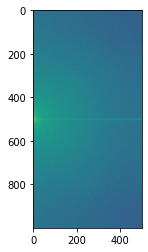

In [34]:
crop = magnitude_db[:, int(magnitude_db.shape[1]/2):]
plt.imshow(crop) # cmap = 'gray'

print(crop.shape)

print(crop.size)

Making the visualisation for FFT 

=== Score is  0


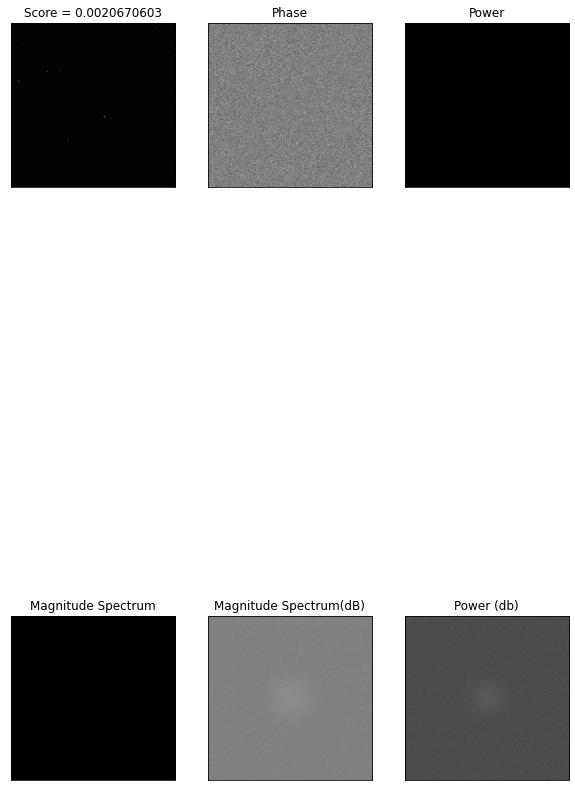

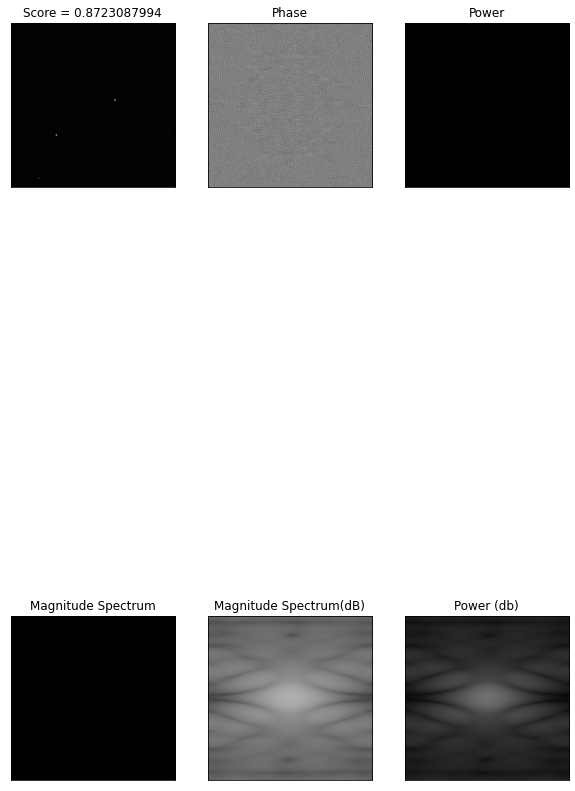

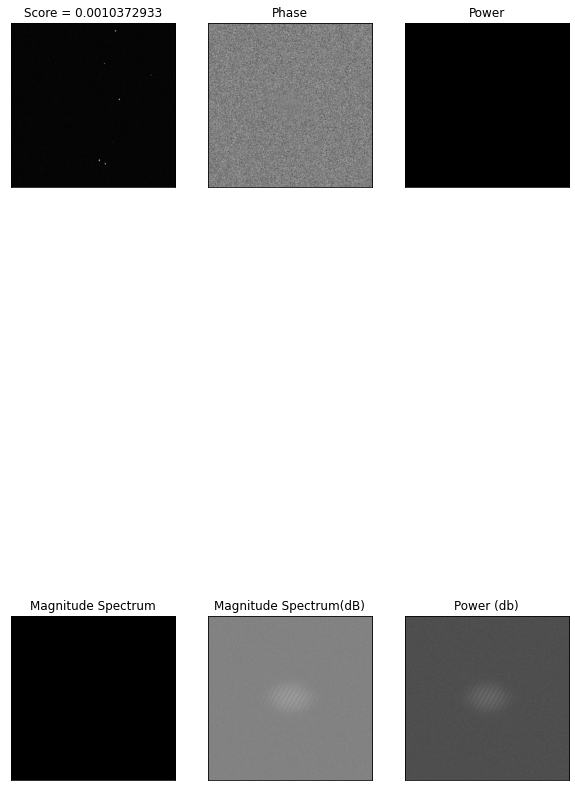

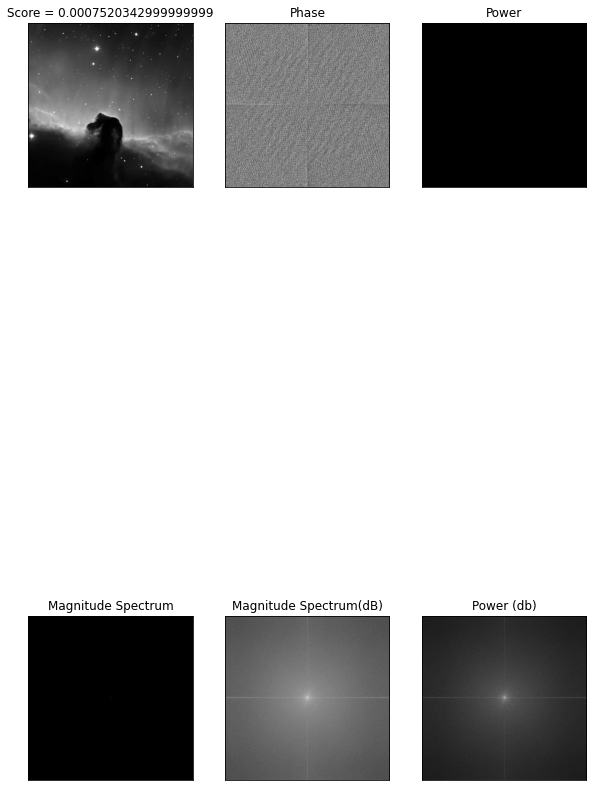

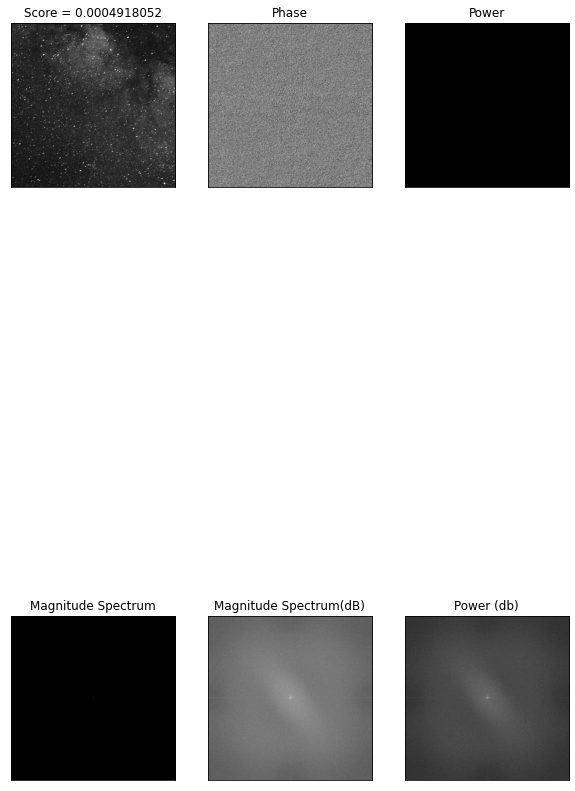

=== Score is  1


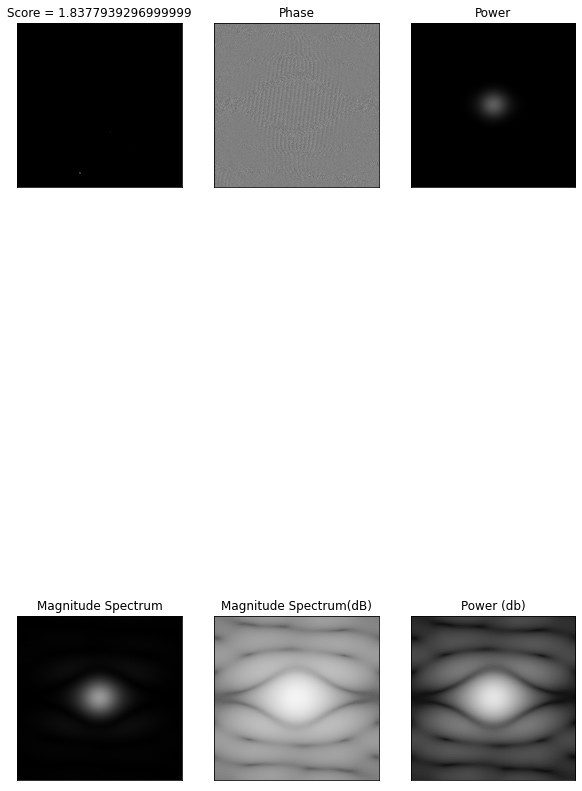

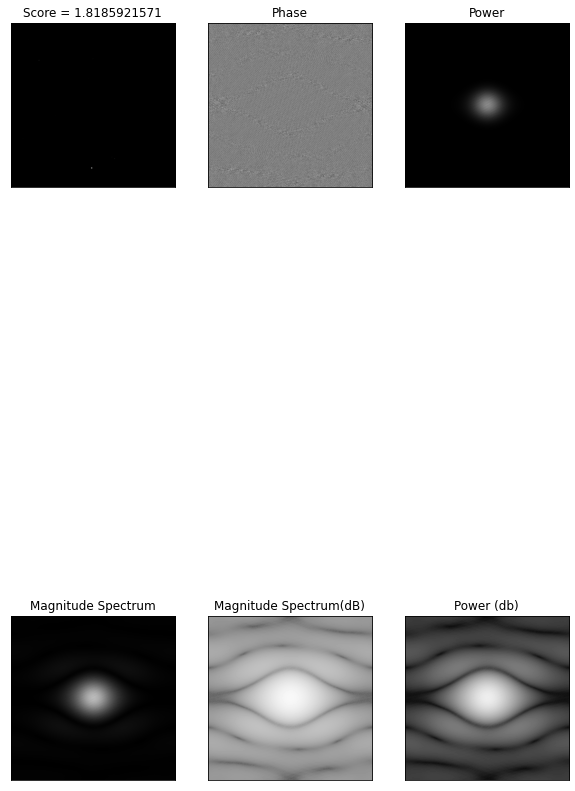

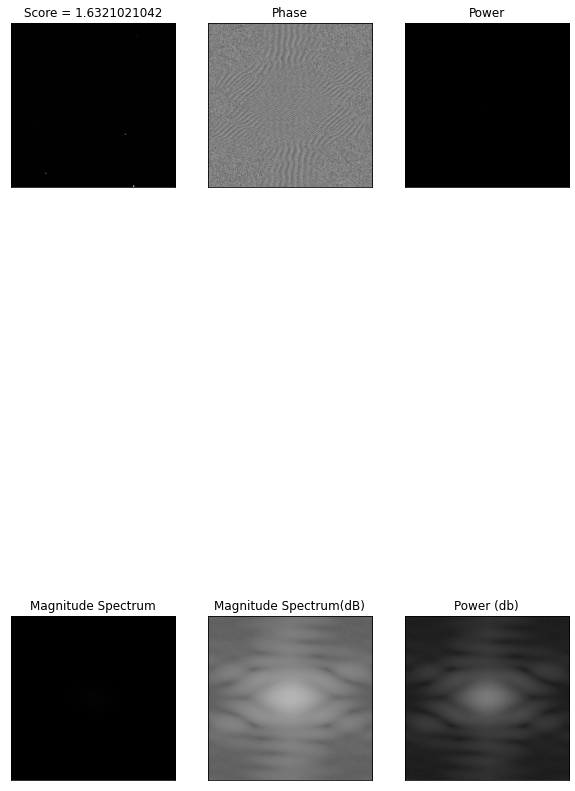

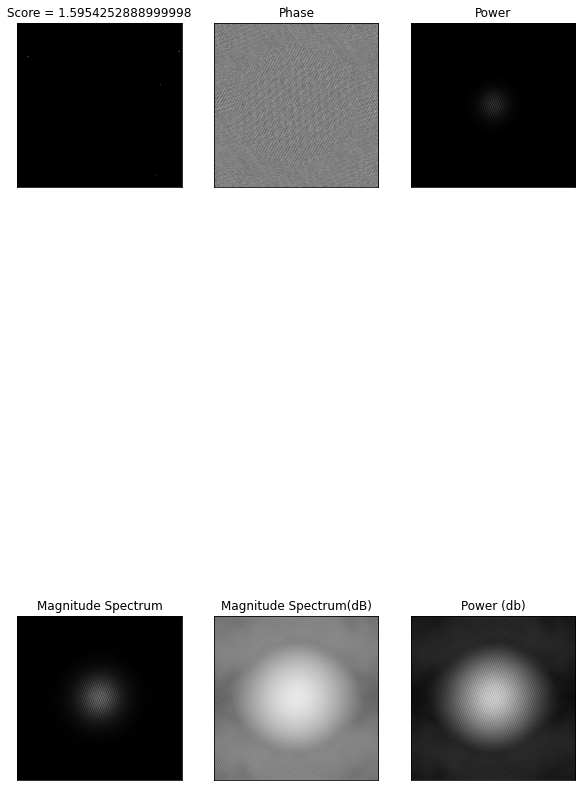

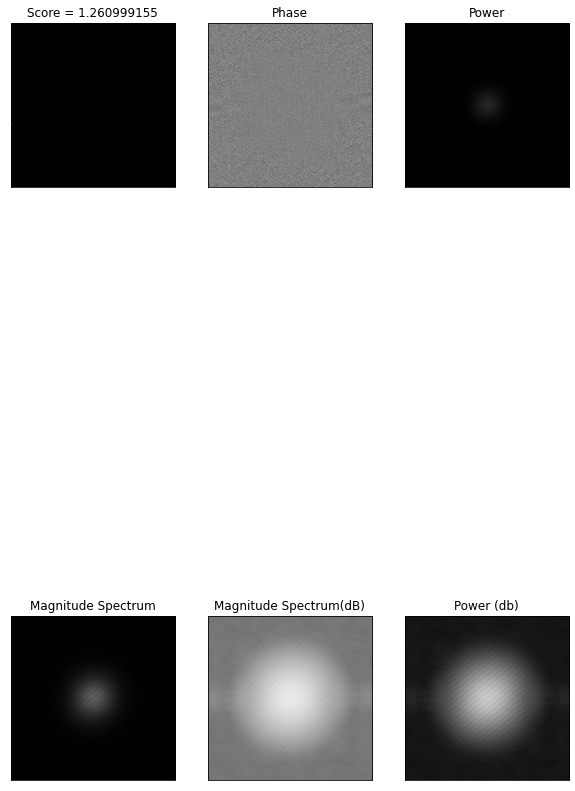

=== Score is  2


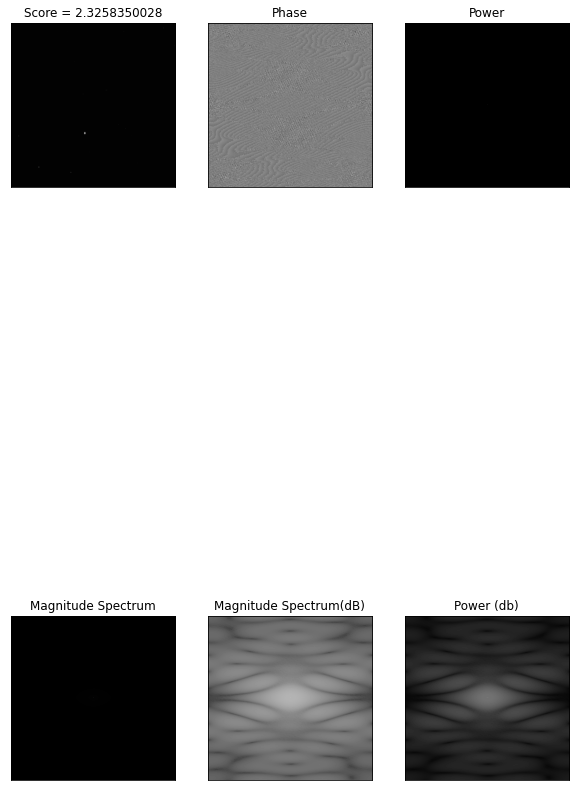

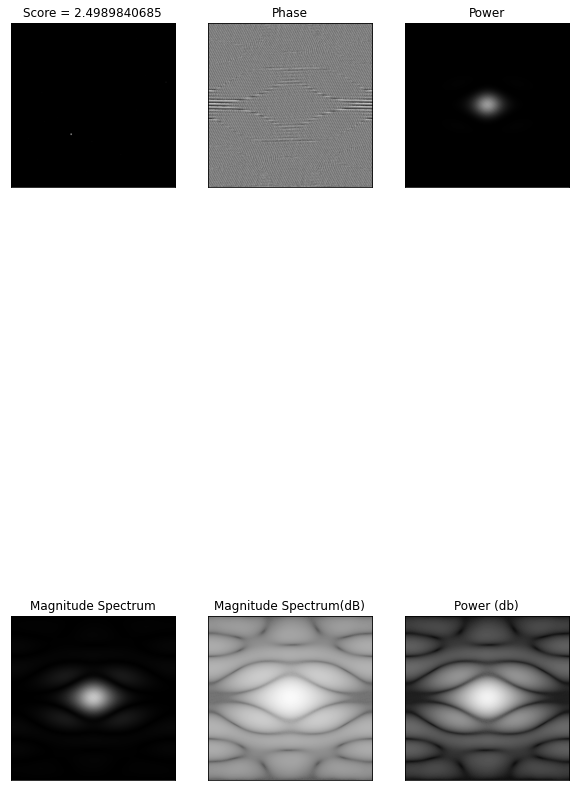

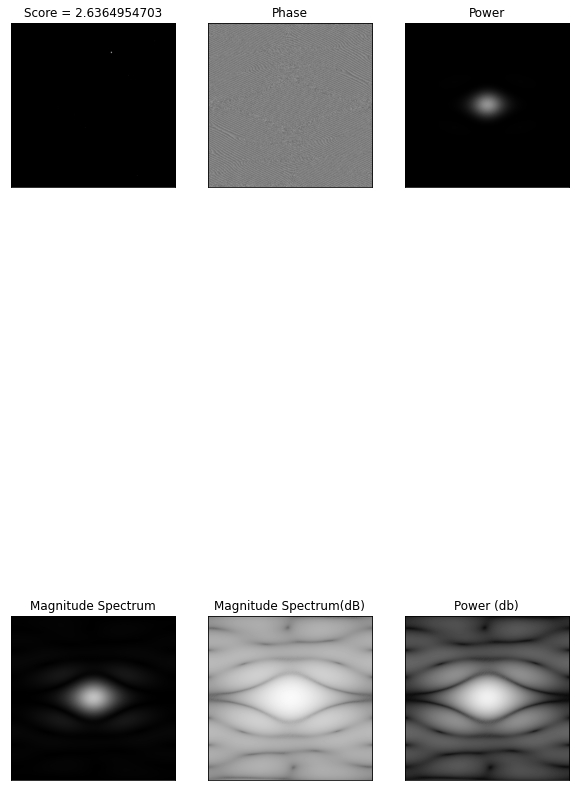

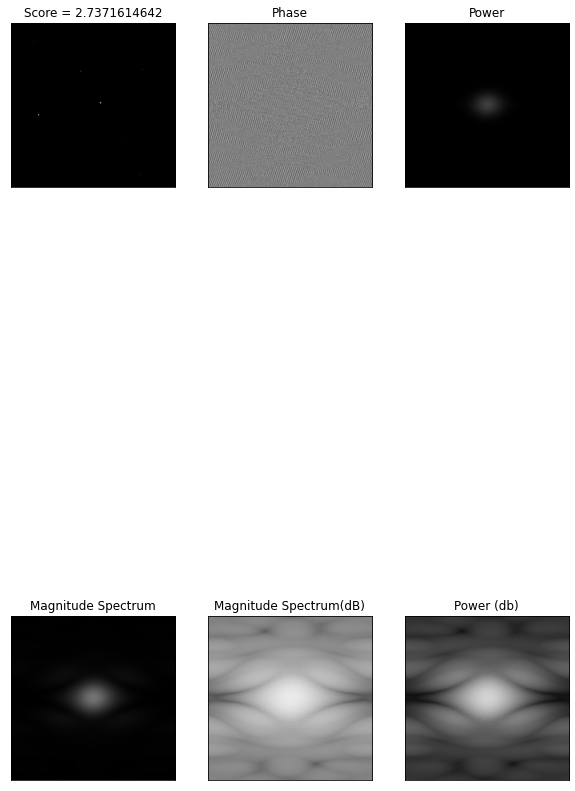

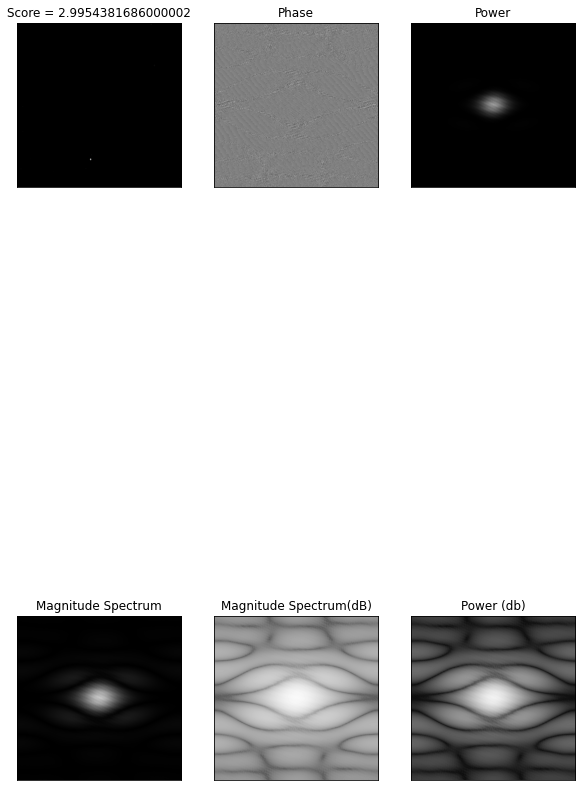

=== Score is  3


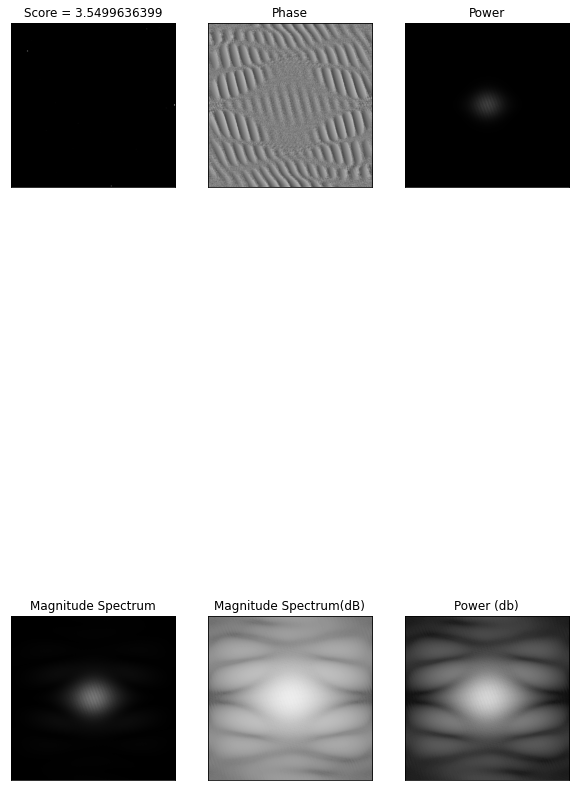

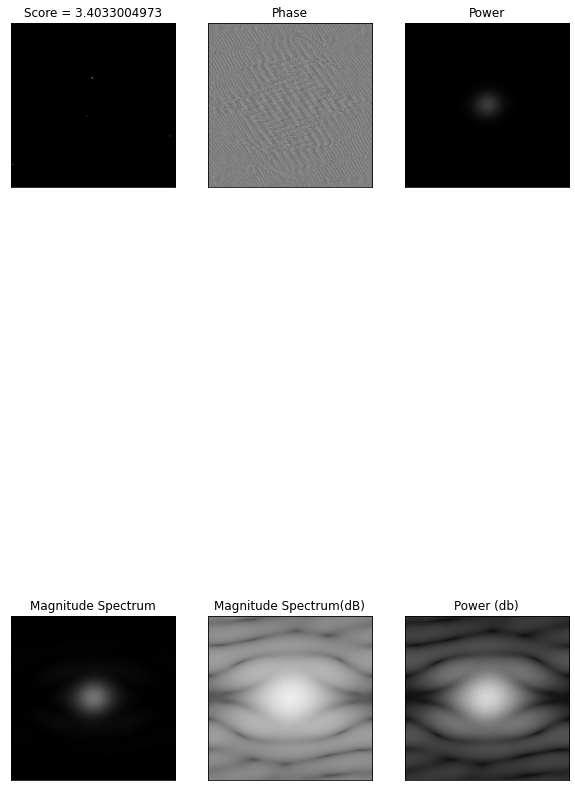

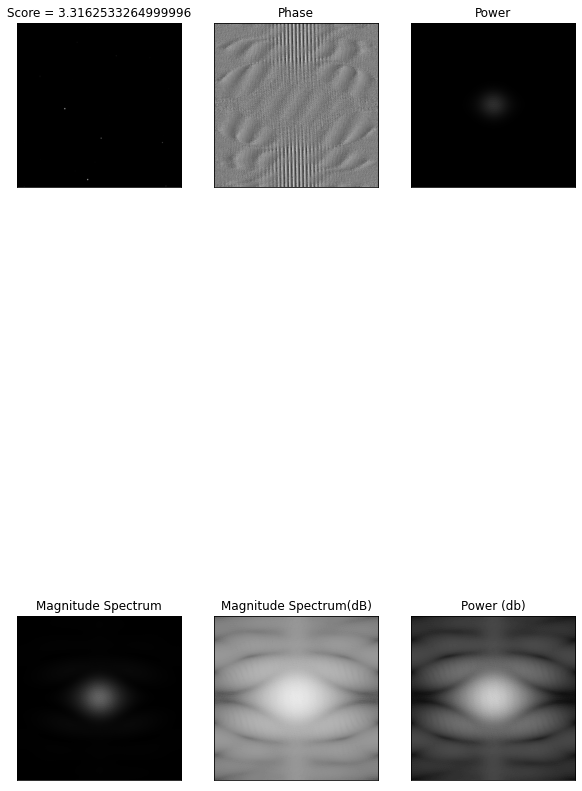

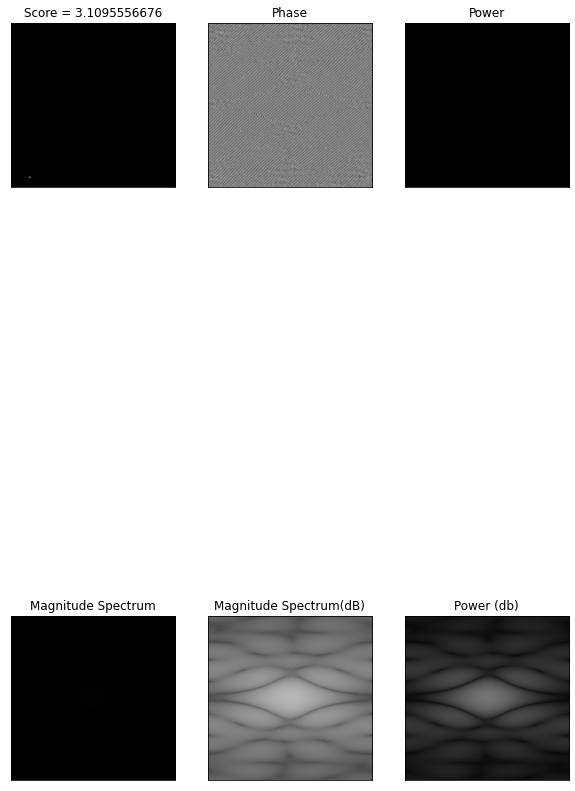

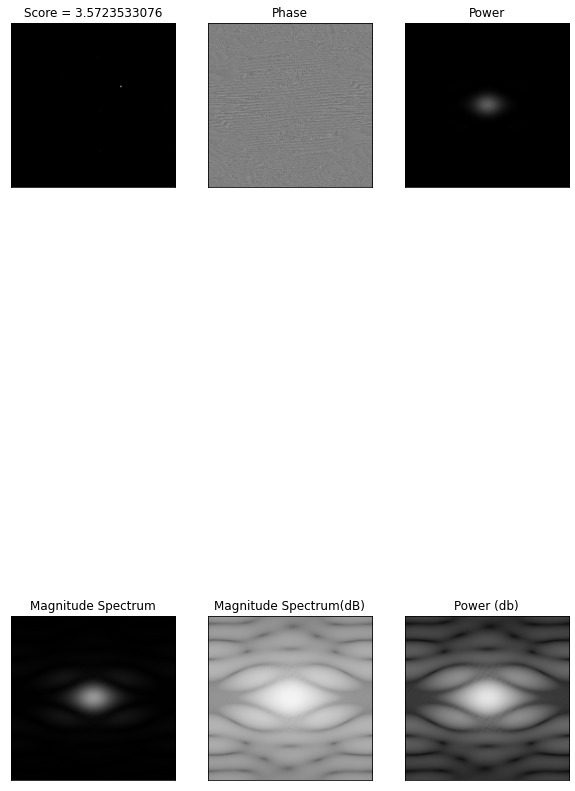

=== Score is  4


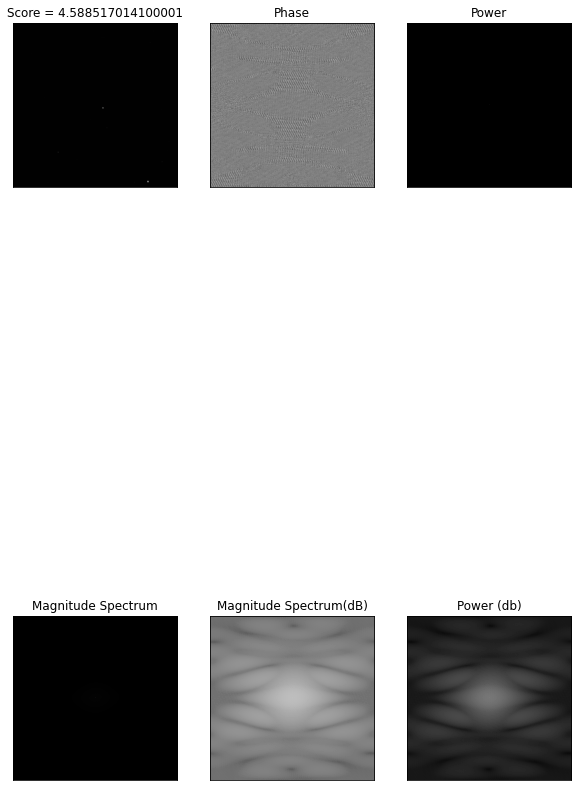

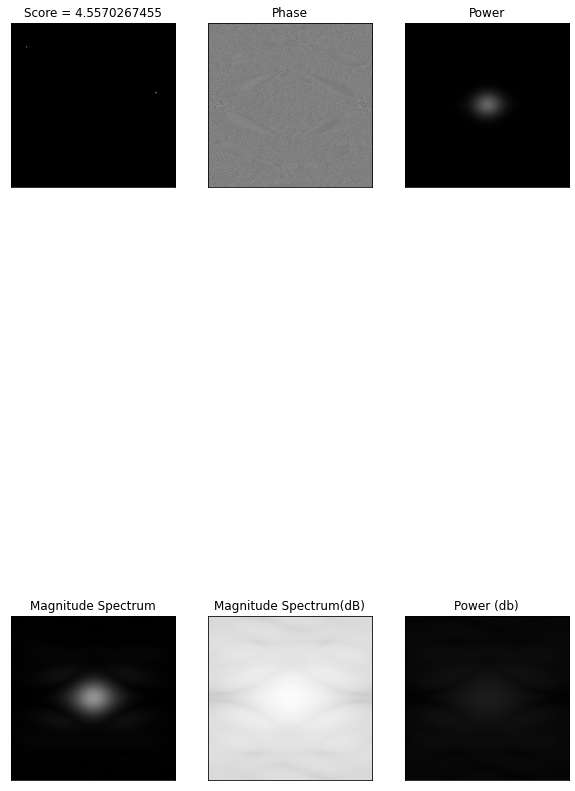

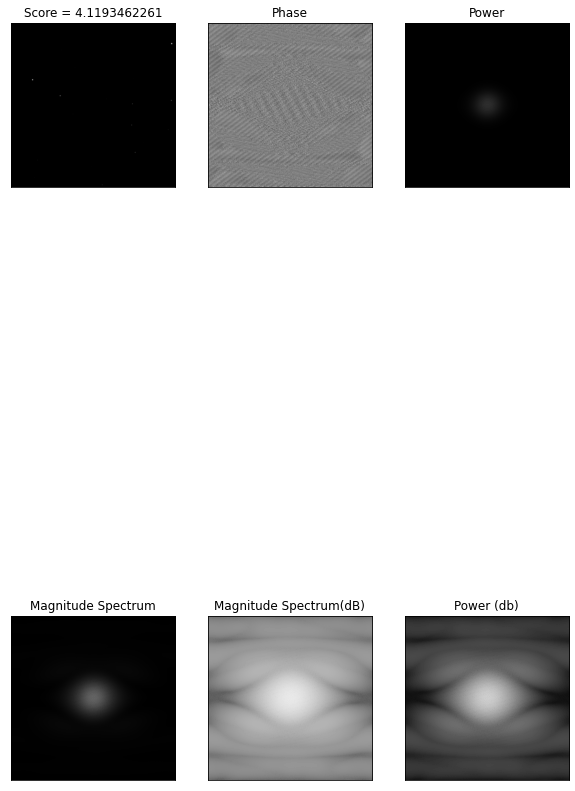

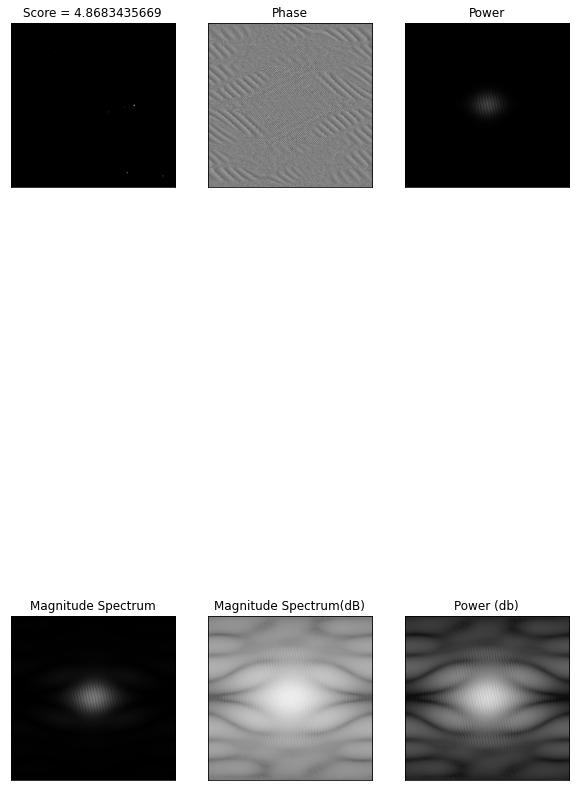

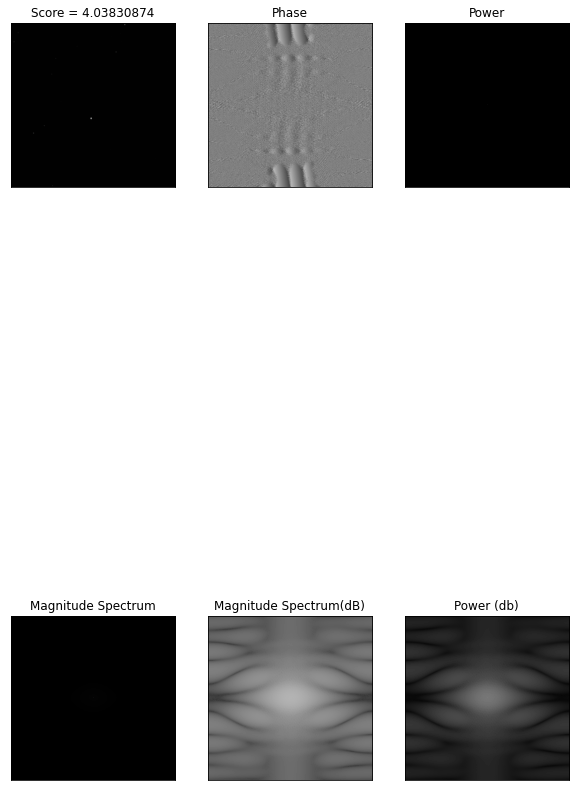

=== Score is  5


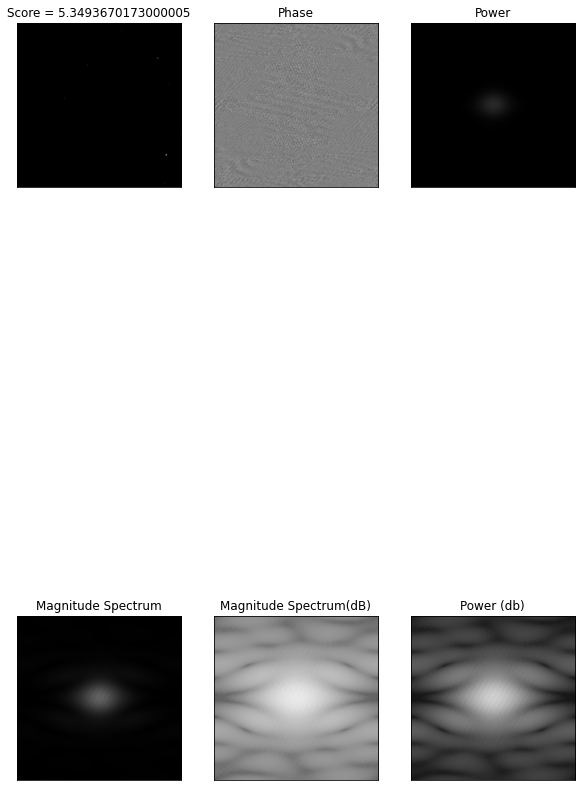

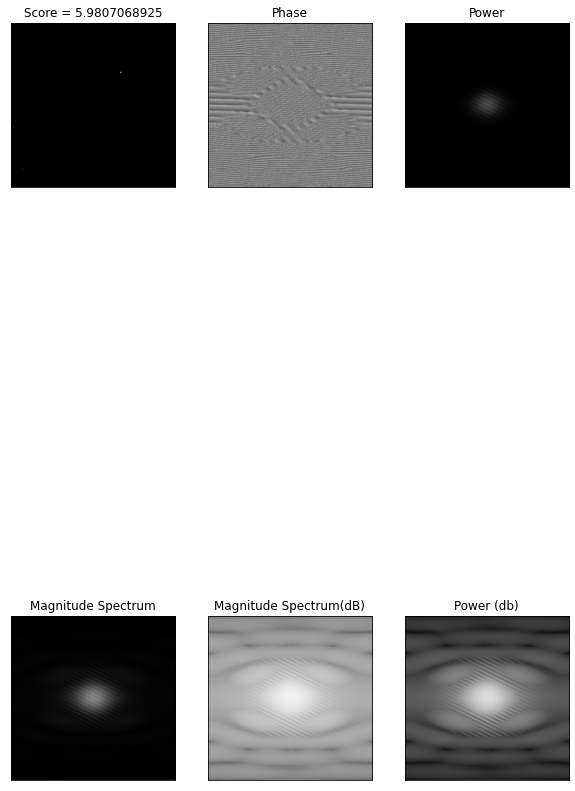

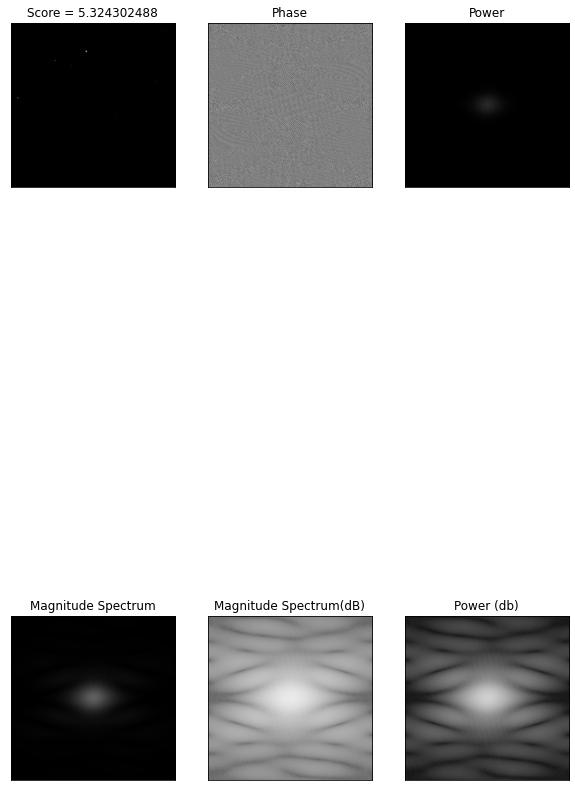

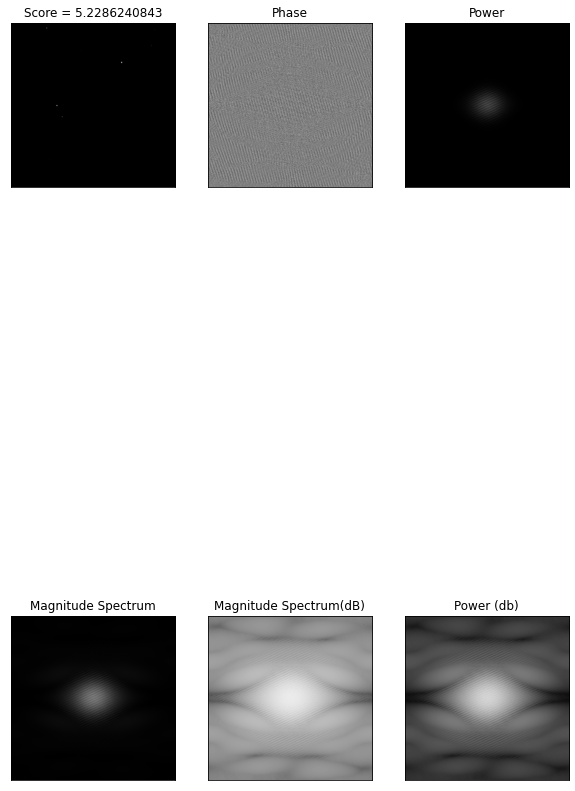

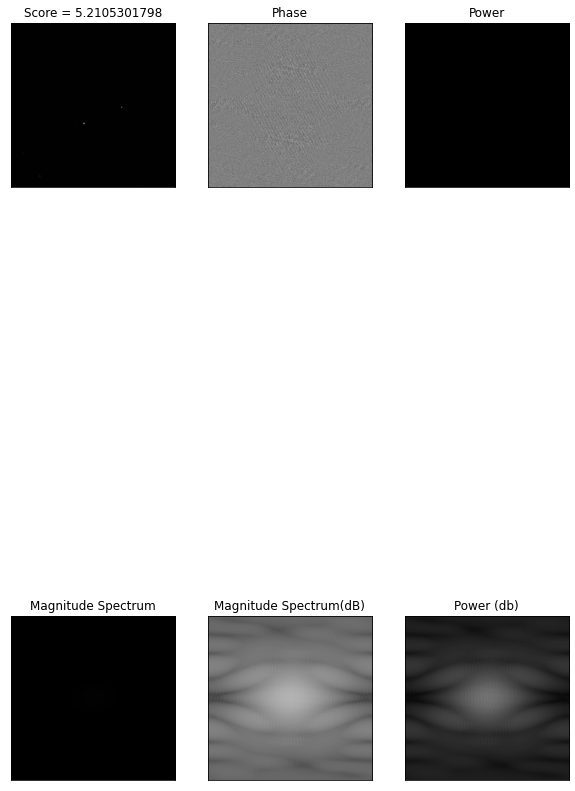

=== Score is  6


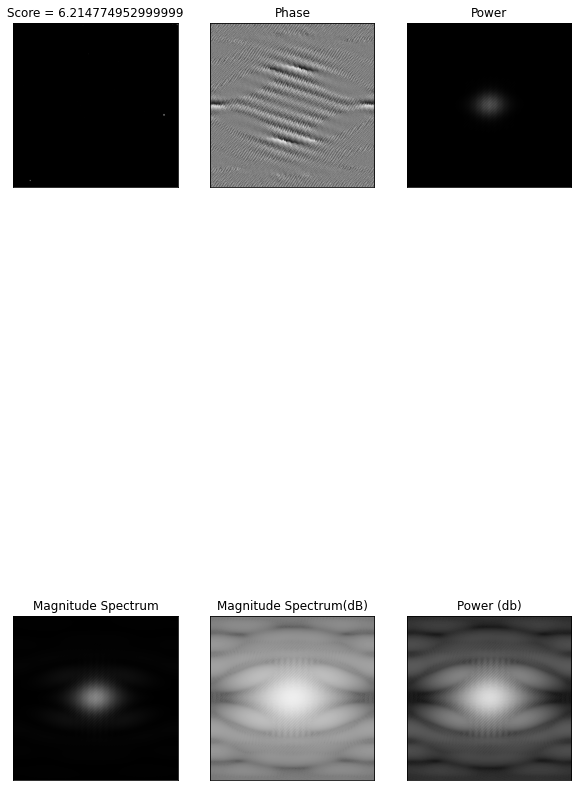

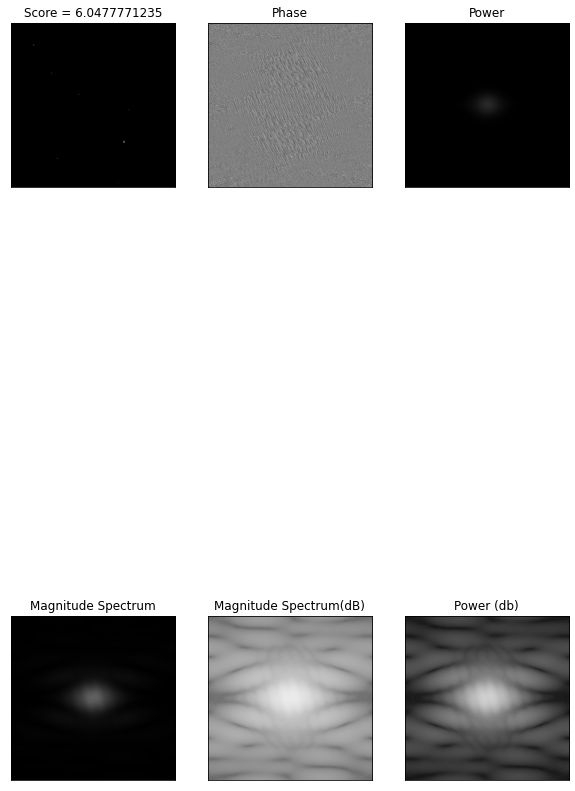

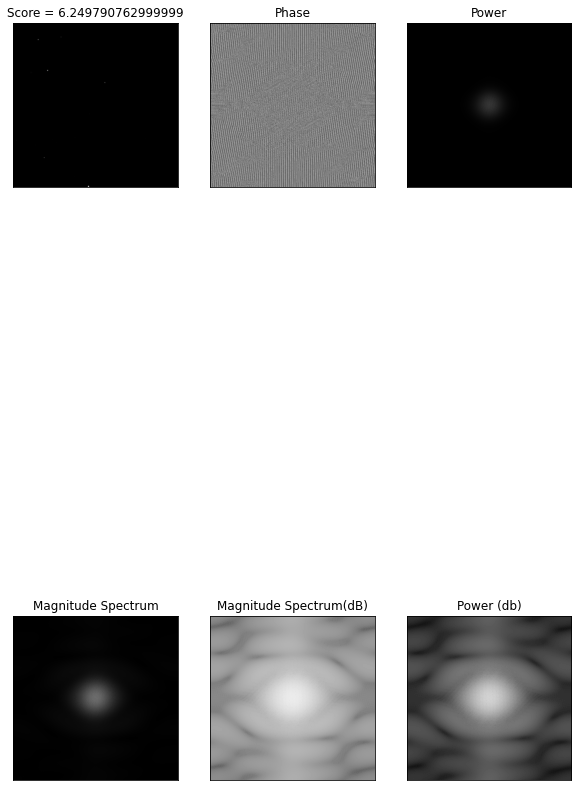

done


In [35]:
for score_thresh in range(7):
  print('=== Score is ', score_thresh)

  # get some images in range [thresh, thresh+1]
  filtered_scores = scores[scores["Actual"] > score_thresh]
  filtered_scores = filtered_scores[filtered_scores["Actual"] < score_thresh+1]
  filtered_scores = filtered_scores[:5] # get only 5 - should be enough
 
  for index, row in filtered_scores.iterrows():
    # Load image
    # print(index)
    img_path = os.path.join(path_scored, str(index) + ".png")
    img = cv2.imread(img_path,0)

    # FFT
    f = np.fft.fft2(img)

    # Move 0 freq to center - not really necessary but images look better 
    fshift = np.fft.fftshift(f)
   
    # Magnitude spectrum
    magnitude_spectrum_db = 20*np.log(np.abs(fshift))
    magnitude_spectrum = np.abs(fshift)

    # Power spectrum
    power_spectrum_db = magnitude_spectrum_db**2 
    power_spectrum = magnitude_spectrum**2

    # Phase
    phase_spectrum = np.angle(fshift)

    plt.figure(figsize=(10, 20))

    plt.subplot(231),plt.imshow(img, cmap = 'gray')
    plt.title('Score = ' + str(row["Actual"])), plt.xticks([]), plt.yticks([])

    plt.subplot(232),plt.imshow(phase_spectrum, cmap = 'gray')
    plt.title('Phase'), plt.xticks([]), plt.yticks([])

    plt.subplot(233),plt.imshow(power_spectrum, cmap = 'gray')
    plt.title('Power'), plt.xticks([]), plt.yticks([])

    plt.subplot(234),plt.imshow(magnitude_spectrum, cmap = 'gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

    plt.subplot(235),plt.imshow(magnitude_spectrum_db, cmap = 'gray')
    plt.title('Magnitude Spectrum(dB)'), plt.xticks([]), plt.yticks([])

    plt.subplot(236),plt.imshow(power_spectrum_db, cmap = 'gray')
    plt.title('Power (db)'), plt.xticks([]), plt.yticks([])
  
    # plt.savefig(save_path + str(score_thresh) + "_" + str(index))
    plt.show()
    plt.close()

print("done")
    